# About the Dataset

This data set provides 1997 birth weight data from National Center for Health Statistics. The data record live, singleton births to mothers between the ages of 18 and 45 in the United States who were classified as black or white. The following steps display information about the data set

In [ ]:
libname PFolio'/folders/myfolders/Assign1';
run;

## Data Exploration
#### First 10 observations for the dataset

In [3]:
title 'First 10 observations';
proc print data = pfolio.birth (obs=10);
run;

Obs,Weight,Black,Married,Boy,MomAge,MomSmoke,CigsPerDay,MomWtGain,Visit,MomEdLevel
1,4111,0,1,1,-3,0,0,-16,1,0
2,3997,0,1,0,1,0,0,2,3,2
3,3572,0,1,1,0,0,0,-3,3,0
4,1956,0,1,1,-1,0,0,-5,3,2
5,3515,0,1,1,-6,0,0,-20,3,0
6,3757,0,1,0,3,0,0,0,3,2
7,2977,1,0,1,-5,1,5,5,3,0
8,3884,0,0,0,-5,0,0,0,3,2
9,3629,0,1,0,6,0,0,-5,3,0
10,3062,0,1,1,-1,0,0,6,3,2


Just by looking at the data set, it can be determined that Black, Married, Boy, MomSmoke, Visits and MomEdLevel seems to be categorical variables. Also, MomAge can not be negative, which indicates that the variable is possibly normailized.

#### Descriptive statistics for continous (int) variables:

In [4]:
title 'Discriptive Stats';
ods noproctitle;
proc means data=pfolio.birth n nmiss min mean std skew kurt max;
    var weight momage cigsperday momwtgain;
run;

Variable,Label,N,N Miss,Minimum,Mean,Std Dev,Skewness,Kurtosis,Maximum
Weight MomAge CigsPerDay MomWtGain,Infant Birth Weight Mother's Age Cigarettes Per Day Mother's Pregnancy Weight Gain,50000 50000 50000 50000,0 0 0 0,240.0000000 -9.0000000 0 -30.0000000,3370.76 0.4161400 1.4766200 0.7092200,566.3850556 5.7284539 4.6540656 12.8761168,-0.7554476 0.2713586 3.8870572 0.4620977,2.6900591 -0.6666093 17.7074723 1.1342923,6350.00 18.0000000 60.0000000 68.0000000


1. No missing values were found
2. Minimum weight for infant is 240 lbs, which should be inspected
3. Minimum weight gain my mother during pregnancy is -30, which is not natural
4. Both Mom-age and Momwtgain seems to be normalized as mean for mom age can't be 0.416

#### Frequency tables


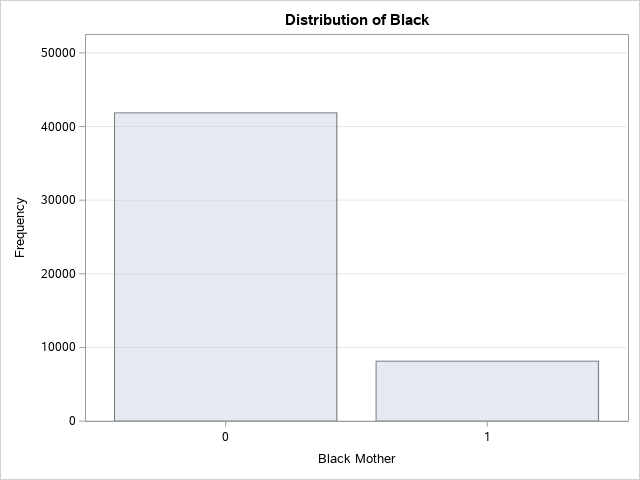
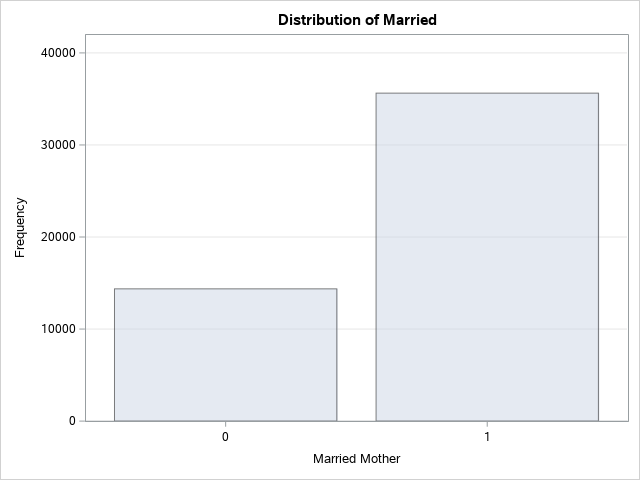
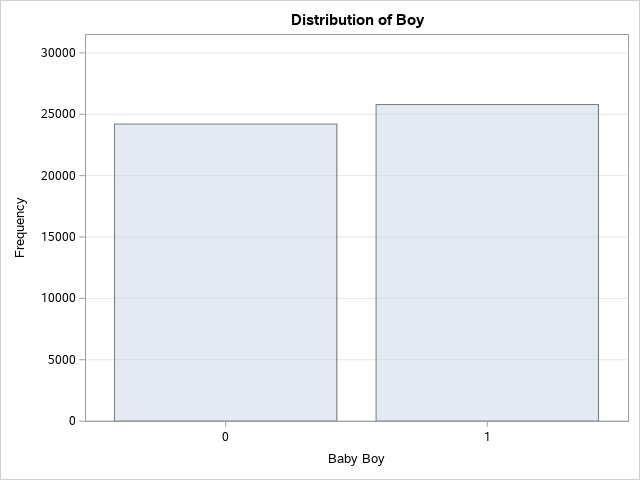
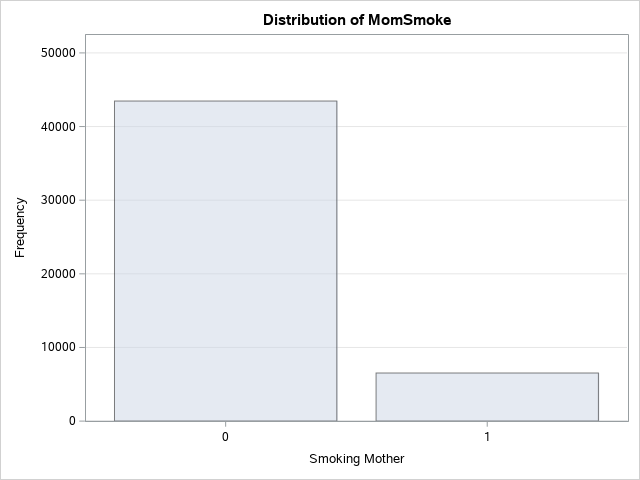
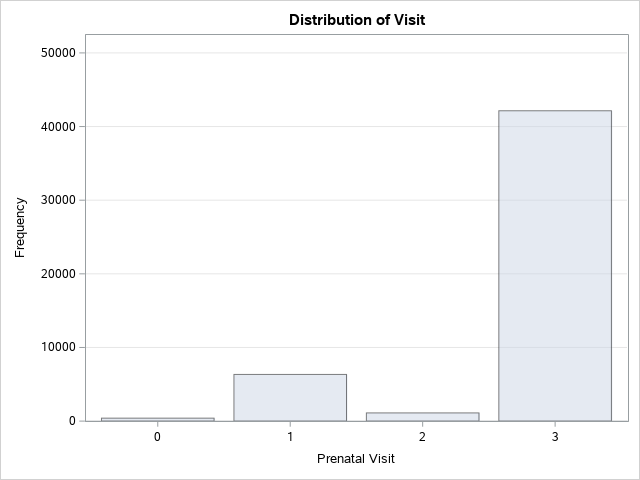
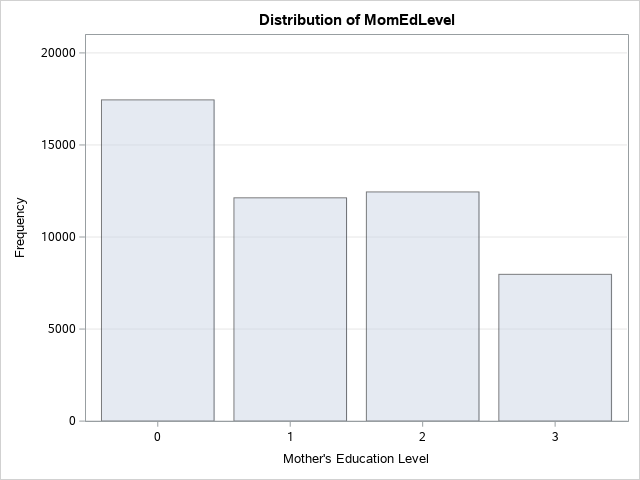

In [5]:
title 'Frequency tables for all categorical variables';
proc freq data=pfolio.birth;
   tables black Married Boy MomSmoke Visit MomEdLevel/ nocum plots=freqplot;
run;


#### Frequency explained for each level:
1. The above graphs indicates that white mothers > Black Mothers
2. Baby boys > Baby girls
3. Non smoking mother > smoking mother
4. Married mother > Un-married mother
5. Mothers making pre-natal visits in third trimester is the highest
6. Highschool education > College > Some college > Less than highschool

#### Further analysis of Infant's birth weight variable


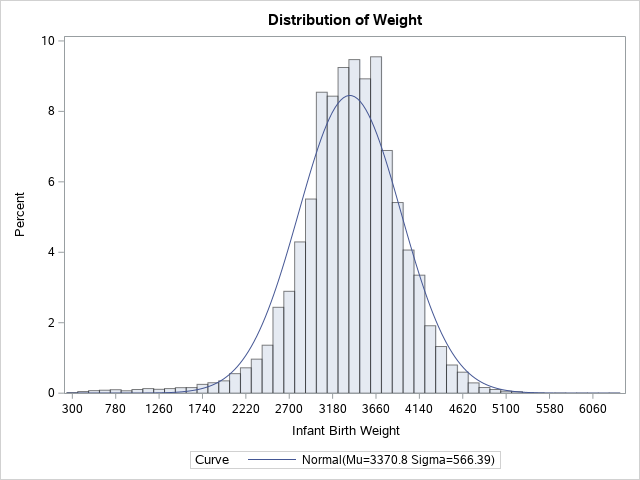
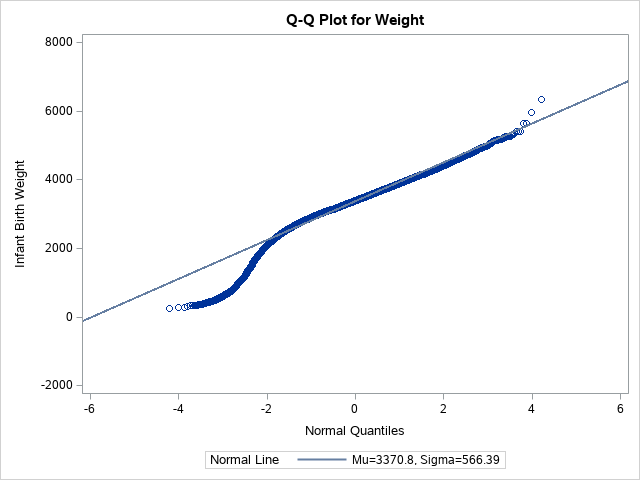

In [6]:
title 'Infant Weight';
ods select histogram ParameterEstimates GoodnessOfFit qqplot;
proc univariate data=pfolio.birth;
	var weight;
	histogram / normaal;
	qqplot/ normal(mu=est sigma=est);
run;

1. The above histogram for infant birth date looks normal, which can be statistically validated by the Kolmogorov-Smirnov test Pr > D < 0.010
2. Also, both QQ plot and histogram indicates that there are significant observations that are less than 2000 lbs. Are they pre-mature under-weight babies??

#### Using the above information and details provided in the data dictonary, a comprehensive Metadata table can be created

## Metadata Table

Variables | Types    | Scale        | Description of Field
--------- | -------- | -----------  | --------------------
Weight    | Numeric  | Continous    | Infant Birth weight in lbs
Black     | Numeric  | Binary [0,1] | Mother's race White(0) = 16.28%, Black(1) = 83.72%
Married   | Numeric  | Binary [0,1] | Mothers' married Status Un-married(0) = 28.74%, Married(1) = 71.26%
Boy       | Numeric  | Binary [0,1] | Infants's gender Girl(0) = 48.72%, Boy(1) = 51.58%
MomSmoke  | Numeric  | Binary [0,1] | Non-smoking mother(0) = 86.93%, Smoking mother(1) = 13.07%
MomAge    | Numeric  | Integer[-9,18]| Mother's age centred at 27 years
CigsPerday| Numeric  | Integer     | Number of ciggerettes smoked 
MomWtGain | Numeric  | Integer[-30,68]| Mother's pregnancy weight gain centred at 30 lbs
Visit     | Numeric  | Categorical  | Prenatal Visits Novisit(0) = 0.81%, First Trimester(1) = 12.68%, Second Trimester(2) = 2.23%, Third Trimester(3) = 84.29%
MomEdLevel| Numeric  | Categorical  | Mother's Edu Level Highschool(0) = 34.90%, Some college(1) = 24.26%, College(2) = 24.90%, Less than highschool(3) = 15.95


#### Univariate Analysis

Several iteration of correlation were performed using both pearson correaltion for continous variables and chisquare test for categorical variables. It was found that MomSmoke and CigsPerday are perfectly correalted. Hence, we can drop MomSmoke as CigsPerDay is more detailed variable

In [7]:
ods noproctitle;
ods select chisq;
proc freq data=Pfolio.birth;
	tables momsmoke*cigsperday / chisq;
run;

Cramer's V vale of 1 indicates a perfect relationship

## Running raw model

In [9]:
ods exclude ParameterEstimates;
proc glm data=pfolio.birth;
class married boy black momage visit cigsperday momedlevel momwtgain;
model weight=married boy black momage visit cigsperday momedlevel 
momwtgain / ss3 solution;
run;

##### ANOVA raw model (all the variables are analyzed, other than MomSmoke to find out if they have significant effect on infant's birth weight)

1. For an ANOVA model, Null hypothesis is, means of all variables are the same and alternate hypothesis is, that atleast one mean is different. In the Overall Anova table, the Pr > F value is <.0001, hence null hypothesis can be rejected and it indicates we have a significant model

2. Also, Pr > F < 0.0001 for all the variables in the model ANOVA table which indictes that all the variables are significant for the model. Although the parameter estimate table suggests grouping for continous variables (CigsPerDay, MomAge, MomWtgain) as their P values indicates that they are not different from their reference level.

### Data Preparation

#### Grouping MomAge


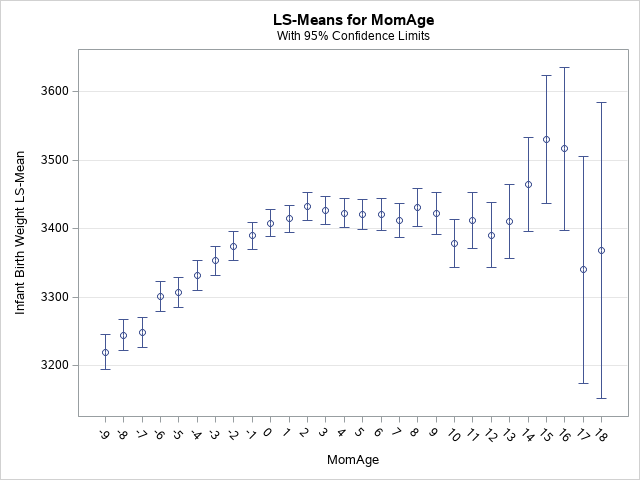

In [2]:
ods select meanplot;
proc glm data=pfolio.birth plots(only)=meanplot(cl);
	class momage;
	model weight=momage / ss3 solution;
	lsmeans momage;
	run;

Using the above LS-Means box plot, iterations were tried keeping in my mind mean of every level. Hence, mom age can be grouped, greater than equal to 0, greater than equal to -4 and greater than equal to -9.

#### Grouping MomWtGain


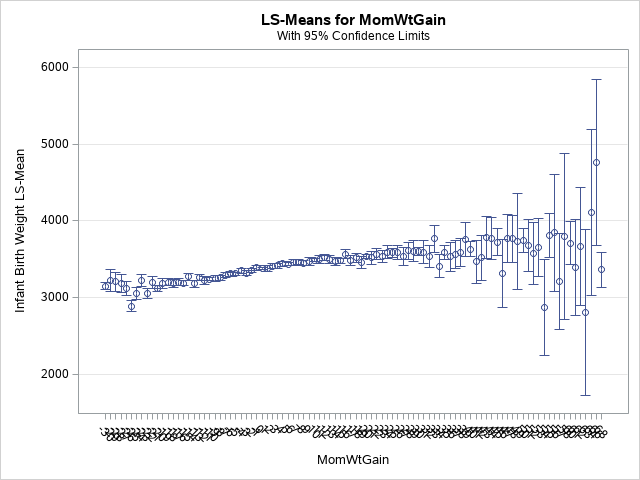

In [4]:
ods select meanplot;
proc glm data=pfolio.birth plots(only)=meanplot(cl);
	class momwtgain;
	model weight=momwtgain ;
	lsmeans momwtgain;
	run;

MomWtGain can be grouped in a similar way i.e. greater than equal to -10, greater than equal to 4 and the rest

#### Grouping CigsPerDay


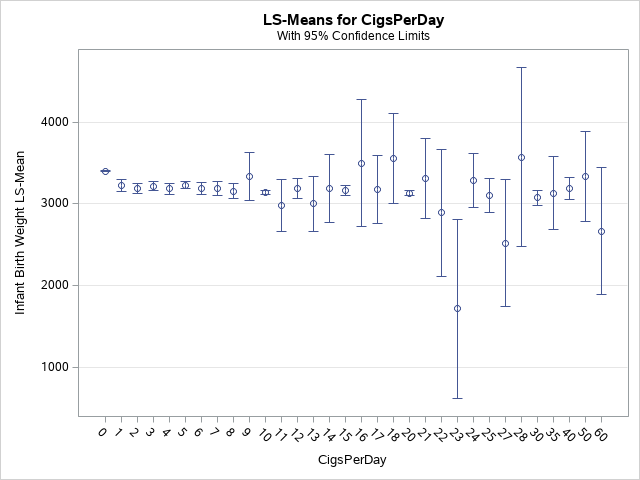

In [15]:
ods select meanplot;
proc glm data=pfolio.birth plots(only)=meanplot(cl);
	class cigsperday;
	model weight=cigsperday ;
	lsmeans cigsperday;
	run;

CigsperDay can be grouped as mothers who doesn't smoke i.e. 0 ciggerettes, less than equal to 5 and anything greater than 5. 

#### Grouping Visits

Prenatal vists can be grouped as, mothers who made no prenatal visits as one group and mothers who made any kind of visit as the other

#### Final Grouping

In [ ]:
data new_birth;
	set pfolio.birth;

	if momage >=0 then
		_momage='0';
	else if momage in (-4:-1) then
		_momage='1';
	else
		_momage='2';

	if momwtgain in (-30:-10) then
		_momwtgain='0';
	else if momwtgain in (-9:4) then
		_momwtgain='1';
	else
		_momwtgain='2';

	if cigsperday <=0 then
		_cigsperday='0';
	else if cigsperday > 0 and cigsperday <=5 then
		_cigsperday='1';
	else
		_cigsperday='2';

	if visit=0 then
		_visit='0';
	else
		_visit='1';

run;

### Main Effect Model (ANOVA)


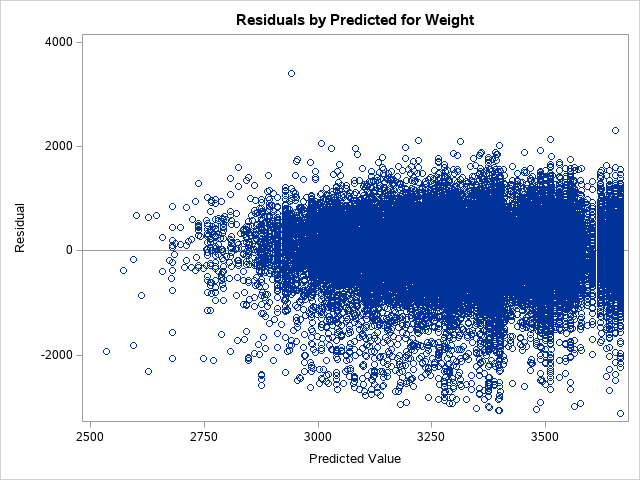
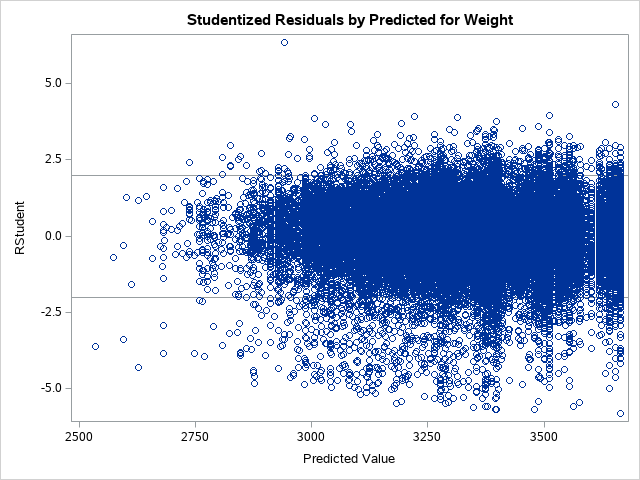
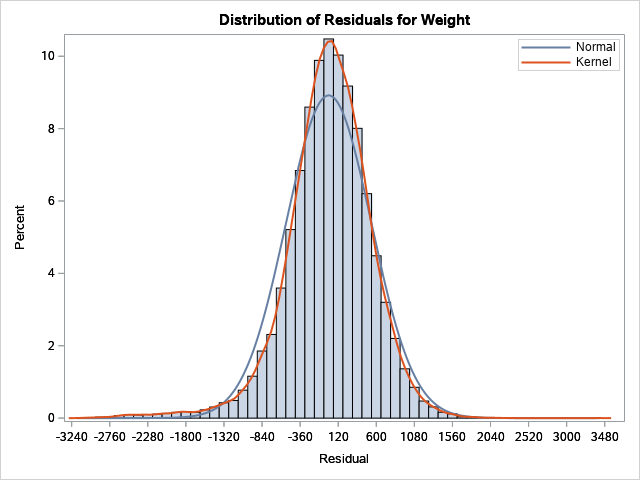
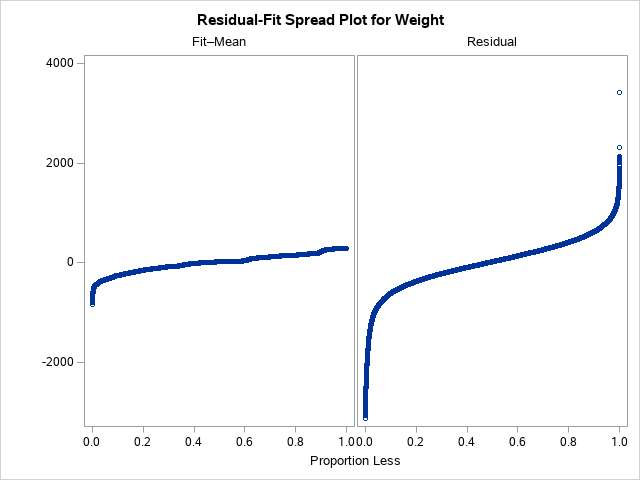

In [7]:
ods exclude CooksDPlot ObservedByPredicted QQPlot RStudentByLeverage   ;
proc glm data=new_birth plots(only maxpoints=none)=(diagnostics(unpack) 
		intplot);
	class married boy black _momage _visit _cigsperday momedlevel _momwtgain;
	model weight=married boy black _momage _visit _cigsperday momedlevel 
		_momwtgain / solution ss3;
	run;


1. After grouping and rerunning the generalized linear model, it was found that all the variables become significant i.e.  Pr > F < 0.0001, which further indicates that we can reject the null hypothesis and conclude that atleast one of the mean is different.
2. R square of .1018 was achieved, which means 10% of the variation can be explained by this model
3. The histogram indicates normal distribution for the residuals
4. Type III Sum of Squares (SS) column can be used to determine impact of each variable on the infant's weight 
 - MomWtGain (506893413.0) is the most contributing variable followed by 
 - CigsPerDay (236976052.9), 
 - Black (221672089.6), 
 - Boy (152063173.4) and so on
5. In the Parameter Estimate table, the Pr > t value is <.0001 for all the levels, hence they are significant and we have a main effect model that can statistically explain the following:
  - If the grand mean of weight is 3118.15, then un-married mothers gave birth to infants that were 61.63 grams lighter
  - Baby girls were 110.40 grams lighter than baby baby boys
  - White mothers gave birth to infants that were 195.65 grams heavier than black mothers
  - Older mothers normally gaves birth to heavier infants
  - Non-smoking mothers gave birth to infants that are 231.64 gms heavier than mothers who smoke more than 5 cigarettes a day
  - Mothers who did not make any pre-natal visits gave birth to infants that are 163.26 gms lighter
  - Also, a postive relationship between education and infant birth weight was found
  - Most importantly, higher the mother's weight during pregnancy, heigher the infant's birth weight. Mothers who are gained upto 20 lbs gave birth to infants who were 266 gms lighter and mothers who gained weight between 20 and 35 lbs gave birth to infants who were 152 gms lighter than mothers who gained more than 35 lbs
  
##### The above model can be expressed with the following equation: 

            -61.63  (Married 0)
            -110.40 (Baby 0)
            -195.65 (Black 0)
            +231.64 (CigsPerDay 0)
            +84.54  (CigsPerDay 1)
            +77.49  (MomAge 0)
            +57.01  (Momage 1)
            -163.04 (Visit 0)
            +17.67  (MomEdLevel 0)
            +30.45  (MomEdLevel 1)
            +41.51  (MomEdLevel 2)
            -266.17 (MomWtGain 0)
            -152.86 (MomWtGain 1)
